# 準備

## ライブラリの準備

In [9]:
import sys

if 'google.colab' in sys.modules:
    !pip install japanize-matplotlib -qqq

In [10]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 人工データの生成

今回使用する人工データは、サインカーブに正規分布に従う乱数をノイズとして加えて生成した。
シード値は関数内で固定しているのでいつも同じ乱数を返す。

数式で表すと、 $\mathcal{N}(\sin(x), (0.5)^2)$ である。

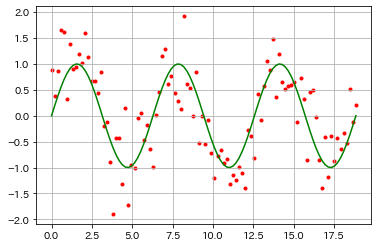

In [11]:
def make_curve(n=100, std=0.5, return_true=False):
    np.random.seed(0)
    x = np.linspace(0, 6*np.pi, n).reshape(-1, 1)
    true = np.sin(x)
    y = true + np.random.normal(scale=0.5, size=[n, 1])
    if return_true:
        return x, y, true
    return x, y

x, y, true = make_curve(return_true=True)
plt.plot(x, true, color="g")
plt.scatter(x, y, marker=".", color="r")
plt.grid(True)

↑真のモデル（緑)と人工データ（赤）の図。

$0 < x < 2.5$ らへんでは、赤点が緑線の上に分布しがちだったり、 $(x, y) = (8, 2)$ らへんに外れ値があったりする。
このようなノイズの影響を受けたデータに対してどのように反応するのかをみると面白い。

## 共通の処理を関数化

In [12]:
def show(x, y, model, pred):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    l.scatter(x, y, marker=".", color="r")
    l.plot(x, model.predict(x))
    r.scatter(x, y, marker=".", color="r")
    r.plot(x, pred, color="k")
    return l, r

# Polynominal（多項式回帰）

## 理論編

非線形回帰をするモデルで教科書的には一番使われるモデル。

　$y(x, w_0, w_1, \dots, w_M) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M$

特徴ベクトルを $\phi(x) = [\phi_0, \phi_1, \phi_2, \dots, \phi_M]^T = [1, x, x^2, \dots, x^M]^T$ と定義すれば、

　$y(x, w) = w_0 \phi_0 + w_1 \phi_1 + w_2 \phi_2 + \cdots + w_M \phi_M = w^T \phi$

と簡単に書ける。この形は、線形基底関数モデルと呼ばれる。  
単回帰は、この特徴ベクトル（基底関数）のうち $\phi_0, \phi_1$ のみを使ったもの。

## 実装編

今回のデータは極値（＝カーブの数）が6個なので7次関数で上手く回帰できるだろう。

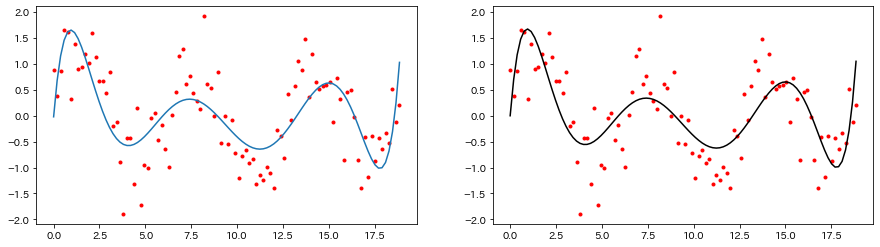

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

trans = PolynomialFeatures(degree=7)
poly = Pipeline([('poly', trans), ('linear', LinearRegression())])

x, y = make_curve()
poly.fit(x, y.ravel())
Phi = trans.fit_transform(x)
W = poly.named_steps['linear'].coef_

show(x, y, model=poly, pred=W @ Phi.T);

## 感想編

両サイドの曲線が急。多項式は $x \to \pm \infty$ のとき発散するので、どうしても外側にいくにつれて変化が強くなりやすい。
正則化でパラメータの値を小さくすれば落ち着きそうだが、Ridgeだと全パラメータの値が平等に小さくなって上手くいってる真ん中部分のバイアスが広がりそうだから、ElasticNetあたりが良いのかな？ でも、どんな対策をしてもデータの範囲外の入力に対する予測精度は悪くなる。

# KernelRidge（カーネル法）

## 理論編

勉強不足なので上手く説明できないけど、線形基底関数モデルを別の視点から見たイメージ。


### 双対定理（duality theorem）

主問題と双対問題のいずれか一方が最適解を持つなら、もう一方も最適解を持ち、主問題の最小値と双対問題の最大値は一致する。
https://ja.wikipedia.org/wiki/%E5%8F%8C%E5%AF%BE%E5%95%8F%E9%A1%8C

今回の場合は、
- 主問題: 普通に、線形基底関数モデルのパラメータを最適化しようとすること。
- 双対問題: カーネル法を使ってパラメータを最適化しようとすること。

ここで、特徴ベクトルは多項式回帰のときと同じく $\phi(x) = [1, x, x^2, \cdots, x^M]^T$ とする。
双対問題を解こうとすると、特徴ベクトルは式中に単体ではなく必ず内積の形で登場する。

具体的に特徴ベクトルの内積を計算してみると、
$$
\phi(x_i)^T \phi(x_j) = 1 + x_ix_j + x_i^2x_j^2 + \cdots + x_i^Mx_j^M
$$
という多項式が得られる。ただ、係数を無視すれば下式でも同じ次数の多項式を得ることができる。
$$
k(x_i, x_j) = (x_i^T x_j + c)^M = \sum_{k=0}^{M} \binom{M}{k} (x_i^T x_j)^k c^{M-k}
$$

この式をカーネル関数と呼び、特徴ベクトル $\phi$ の内積を入力ベクトル $x$ の関数で表せることを「カーネルトリック」と呼ぶ。
（カーネルトリックは $x$ が多次元になったときに効果を発揮する。）

詳しく説明しようとするとボロが出るので、動画を引用しておく。

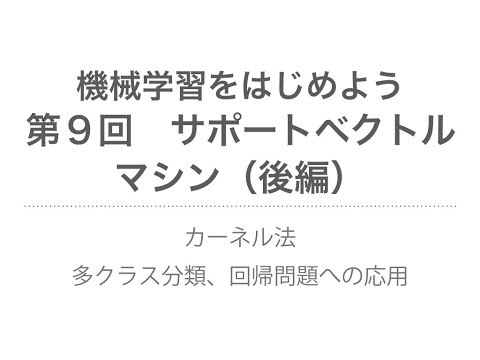

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo("fUSO6-0o3ds")

## 実装編

カーネル関数 $k(x_i, x^*_j)$ を $(i, j)$ 成分とした行列を $K$ 、パラメータを $w$ とおく。
すると、回帰式は、

　$y(x, w) = Kw$

となる。この回帰式の特徴として以下のようなものがある。

- $K$ の列数はデータ数なので、パラメータもデータの数だけ必要になる。
- 毎回予測するときに学習データが全て必要になる。

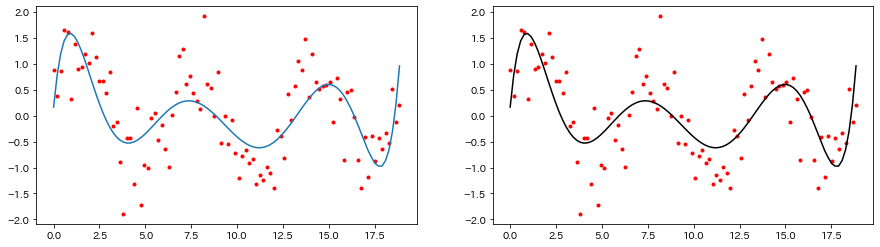

In [15]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel

kr = KernelRidge(kernel="poly", degree=7, coef0=x.mean(), alpha=100000)
kr.fit(x, y)
K = polynomial_kernel(x, x, degree=7, coef0=x.mean())

show(x, y, kr, pred=K @ kr.dual_coef_);

## 感想編

線形回帰とめっちゃ似ている。`sklearn` の仕様で正則化が施されているが、それがなければ理論的には同じになるのかな？  
多項式回帰よりもカーネル法の方が圧倒的に遅かった。この原因は計算量が $O(M^3)$ だったのが $O(N^3)$ になったからかな？

モデルを生成する際に、`coef0` を良い感じの値にする必要があった。カーネル関数が
$$
(X + c)^d = X^d + cX^{d-1} + c^2 X^{d-2} + \cdots + c^{d-1} X + c^d
$$
なので、$|X| > 1$のとき累乗するとどうしても高次成分が爆発する。
（同じ式中に、$X=10$ なら $c10^6$ と $c^6 10$ が一緒に出てくる。）  
なので、低次成分を高次成分に負けないように、定数 $c$ を設定しなければいけないということなのだろうか。

# Support Verctor Machine

## 理論編

学習時の大まかな流れはカーネル法と同じ（だったはず）。
大きな違いが、予測時に使用するデータがカーネル法は全て必要だったが、
SVMの場合は一部の重要なデータだけで良い。
このデータのことをサポートベクターと呼ぶ。
サポートベクターは簡単に言うと、扱うのが難しいベクトルの集まりである。

参考: [SVMとKernelRidge法の違いは何でしょうか？ - Quora](https://jp.quora.com/SVM-to-KernelRidge-hou-no-chigai-ha-nande-shou-ka)

KernelRidge では多項式回帰との比較のために多項式カーネルを指定したが、RBFカーネル（Radial Basis Function, 動径基底関数）の方が有名。

<img src=https://miro.medium.com/max/1750/1*2semMMlw6nrJVhXo78UCLA.png width=800>

指数関数をテイラー展開すると無限次数の多項式がでてくるので、RBF カーネルを用いると暗黙に無限次元の特徴空間で回帰していると見ることができる。（本当かよく分からないけど。）ただ、階乗が分母にあるので機械精度ではそこまで高次元は現れなさそう。

参考: [Understanding the Kernel Trick with fundamentals - towards data science](https://towardsdatascience.com/truly-understanding-the-kernel-trick-1aeb11560769)

## 実装編

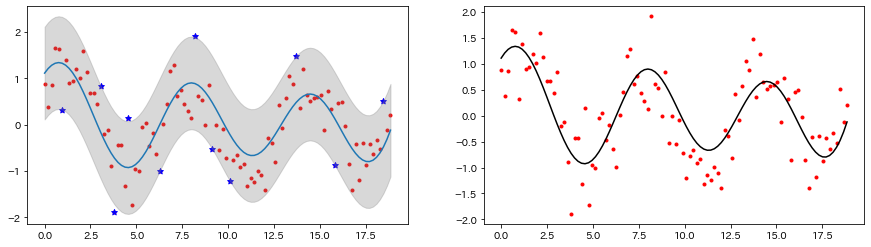

In [16]:
from sklearn.svm import SVR
from sklearn.metrics.pairwise import rbf_kernel

eps = 1
svr = SVR(kernel="rbf", C=1000, epsilon=eps)
x, y = make_curve()
svr.fit(x, y.ravel())

sv = x[svr.support_]
K = rbf_kernel(sv, x, gamma=1 / x.var())
pred = (svr.dual_coef_ @ K) + svr.intercept_
pred = pred.flatten()

l, _ = show(x, y, svr, pred=pred)
l.scatter(x[svr.support_], y[svr.support_], marker="*", color="b")
l.fill_between(x.ravel(), pred-eps, pred+eps, color="gray", alpha=0.3);

## 感想編

特殊な誤差関数を用いることで、グレーの領域（モデルを生成する際に、`epsilon`で指定した幅）のデータは誤差ゼロをして扱われる。
このグレーの領域をはみ出している、青い★のデータがサポートベクターとなる。個人的には回帰式から離れていて扱いが難しそうな店というイメージがある。

なぜか分からないが、左図を見ていると仮免技能試験でS字カーブの縁石にかすった記憶が蘇る。